In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection

from data_preprocess import pre_processing # Used to preprocess data
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('always')

## Random Forest Accelerator for Anomaly Detection
The model takes in a dataframe and several other parameters and outputs a series of whether a point is an anomaly or not

In [2]:
class RandomForestAccel:
    def __init__(self, df, y_label, hypertune=False, rand_forest_params={}, 
                 sequence_matters=False, random_state=42, train_size=0.8,
                 **kwargs):
        """ 
        params:
        df: dataframe which we want to detect the anomaly
        y_label: the y label of which we are predicting
        hypertune: whether or not we want to hypertune the model, if it is false
        then it will use base isolation forest params unless parameters are defined
        rand_forest_params: parameters if we do not want to hypertune the parameters, will 
        be used if hypertune is equal to True
        sequence_matters: True if it is a time series, False otherwise
        train_size: train size for train test split
        """      
        
        # If sequence is true then we will do a sequence split of first (n% and 1-n%)
        # The split is only used if we are hypertuning, other wise
        if sequence_matters == True:
            # Train test train split
            train_size = int(train_size * len(df))
            train, test = df[:train_size], df[train_size:]
        else: # We do a random split, usually for non time series data
            # test train split
            train, test = train_test_split(df, test_size=(1-train_size), random_state=random_state)
            
        # Drop labels here
        X_train = train.drop(y_label, axis=1)
        y_train = train[y_label].values
        X_test = test.drop(y_label, axis=1)
        y_test = test[y_label].values
    
#         if len(rand_forest_params) == 0:
#             rand_forest_params = {'n_estimators': [100, 300, 500, 800, 1200], 
#               'max_depth': [5, 8, 15, 25, 30],
#               'max_features': ['auto', 'sqrt', 'log2'], 
#               'criterion' :['gini', 'entropy'],
#               'min_samples_split': [2, 5, 10, 15, 100],
#               'min_samples_leaf': [1, 2, 5, 10],
#               'n_jobs': [-1]}
             
        if len(rand_forest_params) == 0:
            rand_forest_params = {'n_estimators': [100], 
              'max_depth': [100],
              'max_features': ['log2'], 
              'criterion' :['entropy'],
              'min_samples_split': [50, 100, 150],
              'min_samples_leaf': [5, 10],
              'n_jobs': [-1]}
                
        """
        If we want to hypertune we will use the train test split data to find the best
        model for the scoring metric we defined, we should always hypertune first, to find
        the best parameters, only set hypertune to false once we know the best parameters
        """
        if hypertune == True:
            # Some Grid Search params
            scoring = kwargs.get('scoring', 'f1')
            refit = kwargs.get('refit', True)
            cv = kwargs.get('cv', 10)
            return_train_score = kwargs.get('return_train_score', True)
            
            # For CV hypertuning
            skf = StratifiedKFold(n_splits=cv)
            folds = list(skf.split(X_train, y_train))
            
            rfc = RandomForestClassifier(random_state=random_state, class_weight="balanced")
            
            grid_dt_estimator = model_selection.GridSearchCV(estimator=rfc, param_grid=rand_forest_params, 
                               cv=folds,
                               refit=refit,
                               scoring=scoring,
                              return_train_score=return_train_score,
                              )
            
            grid_dt_estimator.fit(X_train, y_train)
            
            # Save the best model
            self.model = grid_dt_estimator.best_estimator_     
        else:   
            
            # RandomForestClassifier(bootstrap=True, class_weight='balanced',
#                        criterion='entropy', max_depth=100, max_features='log2',
#                        max_leaf_nodes=None, min_impurity_decrease=0.0,
#                        min_impurity_split=None, min_samples_leaf=10,
#                        min_samples_split=100, min_weight_fraction_leaf=0.0,
#                        n_estimators=100, n_jobs=-1, oob_score=False,
#                        random_state=42, verbose=0, warm_start=False)
            n_estimators = kwargs.get('n_estimators', 100)
            max_depth = kwargs.get('max_depth', 100)
            max_features = kwargs.get('max_features', 'log2')
            criterion = kwargs.get('criterion', 'entropy')
            min_samples_split = kwargs.get('min_samples_split', 100)
            min_samples_leaf = kwargs.get('min_samples_leaf', 10)
            n_jobs = kwargs.get('n_jobs', -1)
            
            random_forest = RandomForestClassifier(random_state=random_state,
                                                   class_weight='balanced',
                                                   n_estimators=n_estimators, 
                                                   max_depth=max_depth, 
                                                   max_features=max_features, 
                                                   criterion=criterion, 
                                                   min_samples_split=min_samples_split, 
                                                   min_samples_leaf=min_samples_leaf,
                                                   n_jobs=-1)
            random_forest.fit(X_train, y_train)
            
            self.model = random_forest
            
    def predict(self, data):
        """
        This method predicts anomalies given a dataset that this class was trained on,
        the dataset must have the same columns as the trained model, it will output the 
        an array of anomalies, also returns probabilities for each for ROC_AUC scores
        """
        return self.model.predict(data), self.model.predict_proba(data)[:, 1]
    
    @staticmethod
    def get_scores(y_pred, y_true, scoring='f1', y_proba=None):
        if scoring.startswith('f1'):
            score = f1_score(y_pred, y_true)
        elif scoring.startswith('pre'):
            score = precision_score(y_pred, y_true)
        elif scoring.startswith('rec'):
            score = recall_score(y_pred, y_true)
        elif scoring.startswith('acc'):
            score = accuracy_score(y_pred, y_true)
        elif scoring.startswith('roc'):
            if  y_proba is None:
                score = 'ROC AUC requires probability scores'
            else:
                score = roc_auc_score(y_pred, y_proba)
        else:
            score = f"Scoring Method: {scoring} not implemented"
        return score
    
    @staticmethod
    def get_all_scores(y_pred, y_true, y_proba):
        # This just prints all scores above above
        print(f"ROC_AUC: {RandomForestAccel.get_scores(y_pred, y_true, scoring='roc', y_proba=y_proba):0.2f}")
        print(f"F1: {RandomForestAccel.get_scores(y_pred, y_true, scoring='f1'):0.2f}")
        print(f"Precision: {RandomForestAccel.get_scores(y_pred, y_true, scoring='pre'):0.2f}")
        print(f"Recall: {RandomForestAccel.get_scores(y_pred, y_true, scoring='rec'):0.2f}")
        print(f"Accuracy: {RandomForestAccel.get_scores(y_pred, y_true, scoring='acc'):0.2f}")

    @staticmethod
    def get_confusion_matrix(y_pred, y_true, cmap='coolwarm'):
        plt.figure(figsize=(10,8))
        
        cf_matrix = confusion_matrix(y_test, y_true)
        group_names = ['Non-Anomalies', 'Falsely Flagged Anom', 'Unflagged Anom', 'True Anomalies']
        group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
        
        # Labels combine group names, counts, and percentages
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)] 
        labels = np.asarray(labels).reshape(2,2)
              
        sns.heatmap(cf_matrix, annot=labels, fmt="", cmap=cmap)

##### Preprocess the Data

In [3]:
df = pre_processing(pd.read_csv("data.csv"))

##### Set aside some data that the model doesn't see so that we can calculate how well the model does

In [4]:
# We will set aside 20% of the data
train_size = 0.8
y_label = 'default_ind'

# Split data 
train_size = int(train_size * len(df))
train, test = df[:train_size], df[train_size:]

# Test is for testing purposes later
X_test = test.drop(y_label, axis=1)
y_test = test[y_label].values

##### Model 

In [5]:
rand_forest = RandomForestAccel(df=df, y_label=y_label, hypertune=False)

##### Confusion Matrix

C:\Users\Himanshu\Anaconda3\lib\site-packages\seaborn\matrix.py:268: PendingDeprecationWarning: 
The label function will be deprecated in a future version. Use Tick.label1 instead.
  fontsize = tick.label.get_size()
C:\Users\Himanshu\Anaconda3\lib\site-packages\seaborn\matrix.py:268: PendingDeprecationWarning: 
The label function will be deprecated in a future version. Use Tick.label1 instead.
  fontsize = tick.label.get_size()


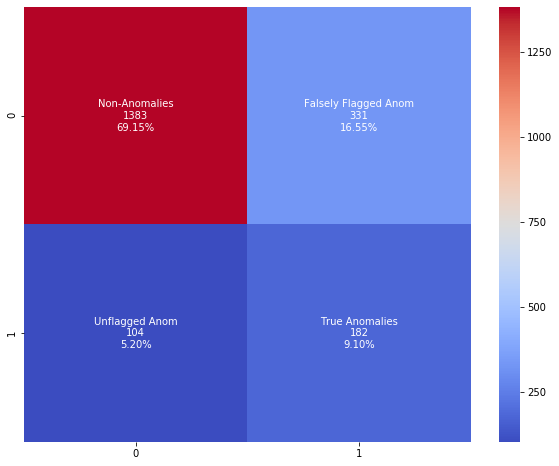

In [6]:
y_pred = rand_forest.predict(X_test)
rand_forest.get_confusion_matrix(np.array(y_test), y_pred[0])

In [7]:
rand_forest.get_all_scores(y_test, y_pred[0], y_proba=y_pred[1])

ROC_AUC: 0.82
F1: 0.46
Precision: 0.35
Recall: 0.64
Accuracy: 0.78


In [8]:
rand_forest.model

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=100, max_features='log2',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=10,
                       min_samples_split=100, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [9]:
# RandomForestClassifier(bootstrap=True, class_weight='balanced',
#                        criterion='entropy', max_depth=100, max_features='log2',
#                        max_leaf_nodes=None, min_impurity_decrease=0.0,
#                        min_impurity_split=None, min_samples_leaf=10,
#                        min_samples_split=100, min_weight_fraction_leaf=0.0,
#                        n_estimators=100, n_jobs=-1, oob_score=False,
#                        random_state=42, verbose=0, warm_start=False)